## Summary

<https://genomeinterpretation.org/cagi6-mthfr.html>

## Google colab

In [ ]:
try:
    import google.colab
    GOOGLE_COLAB = True
except ImportError:
    GOOGLE_COLAB = False
    
GOOGLE_COLAB

True

In [ ]:
if GOOGLE_COLAB:
    from google.colab import drive
    drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Imports

In [ ]:
import glob
import matplotlib.pyplot as plt
import urllib.request
import zipfile
from pathlib import Path

import numpy as np
import pandas as pd

## Parameters

In [ ]:
NOTEBOOK_DIR = Path("20_cagi6_mthfr").resolve()
NOTEBOOK_DIR.mkdir(exist_ok=True)

NOTEBOOK_DIR

PosixPath('/content/20_cagi6_mthfr')

## Helper functions

In [ ]:
def download(url, filename):
    urllib.request.urlretrieve(url, filename)


def download_and_unzip(url, output_dir):
    zip_path, _ = urllib.request.urlretrieve(url)
    with zipfile.ZipFile(zip_path, "r") as f:
        f.extractall(output_dir)

In [ ]:
def get_min_max(filename):
    df = pd.read_csv(NOTEBOOK_DIR.joinpath(filename), names=["mut_ref"])
    if "WT" in filename:
        df["aa_wt"], df["aa_pos"], df["aa_mut"] = (
            list(zip(*df["mut_ref"].str.findall("^p\.([a-zA-Z]+)([0-9]+)([a-zA-Z]+)").str[0]))
        )
    else:
        df["aa_wt"], df["aa_pos"], df["aa_mut"] = (
            list(zip(*df["mut_ref"].str.findall("^p\.\[([a-zA-Z]+)([0-9]+)([a-zA-Z]+)").str[0]))
        )
    df["aa_pos"] = df["aa_pos"].astype(int)
    return df["aa_pos"].min(), df["aa_pos"].max()

In [ ]:
def distribution_to_score(distribution, seed):
    rng = np.random.default_rng(42)

    results = []
    for bin, count in distribution.items():
        low, high = [float(f) for f in bin.strip("[]").split(";")]
        scores = rng.uniform(low, high, count).tolist()
        results.append(scores)
    result = np.hstack(results)
    result.sort()
    return pd.Series(result)

In [ ]:
def add_dist_columns(df, columns, scores):
    for column in columns:
        df = df.sort_values(column).reset_index(drop=True)
        df = df.join(scores.rename(f"{column}_dist"))
    df = df.sort_values(["aa_pos", "mut"])
    return df

## Workspace

### Download data

In [ ]:
# Challenge data
download_and_unzip("https://genomeinterpretation.org/download/mthfrvariants.zip", NOTEBOOK_DIR)
download_and_unzip("https://genomeinterpretation.org/download/distributions.zip", NOTEBOOK_DIR)
download_and_unzip("https://genomeinterpretation.org/download/mthfrtemplate.zip", NOTEBOOK_DIR)
download("https://genomeinterpretation.org/download/mthfrvalidation.py", NOTEBOOK_DIR.joinpath("mthfrvalidation.py"))

In [ ]:
!ls {NOTEBOOK_DIR}

cataAV_variants.txt  distributions.csv	mthfrtemplate	    reguAV_variants.txt
cataWT_variants.txt  __MACOSX		mthfrvalidation.py  reguWT_variants.txt


In [ ]:
!ls {NOTEBOOK_DIR}/mthfrtemplate

cataAV_template.tsv  reguAV_template.tsv
cataWT_template.tsv  reguWT_template.tsv


In [ ]:
df = pd.read_csv(NOTEBOOK_DIR / "mthfrtemplate" / "cataWT_template.tsv", sep="\t")

df.head()

,AA_substitution,Score,Std,Comment
0,Ala113Arg,*,*,*
1,Ala113Asn,*,*,*
2,Ala113Cys,*,*,*
3,Ala113Glu,*,*,*
4,Ala113Gly,*,*,*


### Load data

In [ ]:
get_min_max("cataWT_variants.txt")

(2, 336)

In [ ]:
get_min_max("reguWT_variants.txt")

(337, 656)

In [ ]:
get_min_max("cataAV_variants.txt")

(2, 336)

In [ ]:
get_min_max("reguAV_variants.txt")

(337, 656)

In [ ]:
distributions_df = pd.read_csv(NOTEBOOK_DIR / "distributions.csv")

distributions_df.head(2)

,bin,catalytic.WT,catalytic.A222V,regulatory.WT,regulatory.A222V
0,[0.00;0.05],925,1168,127,225
1,[0.05;0.10],129,297,12,53


### Load results

In [ ]:
DATA_DIR = Path("/gdrive/MyDrive/CAGI6/MTHFR/").resolve(strict=True)

!ls {DATA_DIR}

ostrokach_cataAV_model_1.tsv  variants-a222v-2021-06-19T18-0001-of-0006.csv
ostrokach_cataAV_model_2.tsv  variants-a222v-2021-06-19T19-0002-of-0006.csv
ostrokach_cataAV_model_3.tsv  variants-a222v-2021-06-19T19-0003-of-0006.csv
ostrokach_cataWT_model_1.tsv  variants-a222v-2021-06-19T19-0004-of-0006.csv
ostrokach_cataWT_model_2.tsv  variants-a222v-2021-06-19T19-0005-of-0006.csv
ostrokach_cataWT_model_3.tsv  variants-a222v-2021-06-19T19-0006-of-0006.csv
ostrokach_desc.txt	      variants-wt-2021-06-19T18-0001-of-0006.csv
ostrokach_reguAV_model_1.tsv  variants-wt-2021-06-19T19-0002-of-0006.csv
ostrokach_reguAV_model_2.tsv  variants-wt-2021-06-19T19-0003-of-0006.csv
ostrokach_reguAV_model_3.tsv  variants-wt-2021-06-19T19-0004-of-0006.csv
ostrokach_reguWT_model_1.tsv  variants-wt-2021-06-19T19-0005-of-0006.csv
ostrokach_reguWT_model_2.tsv  variants-wt-2021-06-19T19-0006-of-0006.csv
ostrokach_reguWT_model_3.tsv


In [ ]:
feature_columns = ["protbert_score", "proteinsolver_score", "el2_score"]

In [ ]:
files = sorted(DATA_DIR.glob("variants-wt-*-of-0006.csv"))
assert len(files) == 6

dfs = []
for file in files:
    df = pd.read_csv(file, sep="\t")
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
df["el2_score"] = -df["el2_score"].values

variants_cata_wt_df = add_dist_columns(
    df[df["aa_pos"] <= 336],
    feature_columns,
    distribution_to_score(distributions_df.set_index("bin")["catalytic.WT"], 0)
)

variants_regu_wt_df = add_dist_columns(
    df[df["aa_pos"] >= 337],
    feature_columns,
    distribution_to_score(distributions_df.set_index("bin")["regulatory.WT"], 1)
)

In [ ]:
files = sorted(DATA_DIR.glob("variants-a222v-*-of-0006.csv"))
assert len(files) == 6

dfs = []
for file in files:
    df = pd.read_csv(file, sep="\t")
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
df["el2_score"] = -df["el2_score"].values

variants_cata_av_df = add_dist_columns(
    df[df["aa_pos"] <= 336],
    feature_columns,
    distribution_to_score(distributions_df.set_index("bin")["catalytic.A222V"], 2)
)

variants_regu_av_df = add_dist_columns(
    df[df["aa_pos"] >= 337],
    feature_columns,
    distribution_to_score(distributions_df.set_index("bin")["regulatory.A222V"], 3)
)

### Save results

In [ ]:
def create_result_df(df, column):
    df = df.copy()
    df["Std"] = 0.25 + 0.75 * (df["aa_pos"] < 39)
    df = df[["mut_3char", column, "Std"]].rename(columns={"mut_3char": "AA_substitution", column: "Score"}).copy()
    df["Comment"] = "*"
    return df

In [ ]:
final_score_columns = [
    "el2_score_dist", "proteinsolver_score_dist", "protbert_score_dist",
    "el2_score", "proteinsolver_score", "protbert_score",
]

for idx, column in enumerate(final_score_columns):
    _ = (
        create_result_df(variants_cata_wt_df, column)
        .to_csv(DATA_DIR / f"ostrokach_cataWT_model_{idx + 1}.tsv", sep="\t", index=False)
    )
    _ = (
        create_result_df(variants_cata_av_df, column)
        .to_csv(DATA_DIR / f"ostrokach_cataAV_model_{idx + 1}.tsv", sep="\t", index=False)
    )
    _ = (
        create_result_df(variants_regu_wt_df, column)
        .to_csv(DATA_DIR / f"ostrokach_reguWT_model_{idx + 1}.tsv", sep="\t", index=False)
    )
    _ = (
        create_result_df(variants_regu_av_df, column)
        .to_csv(DATA_DIR / f"ostrokach_reguAV_model_{idx + 1}.tsv", sep="\t", index=False)
    )

In [ ]:
%%file {DATA_DIR}/ostrokach_desc.txt
Predictions were generated using ELASPIC2 (https://gitlab.com/elaspic/elaspic2).

They can be reproduced using the following Colab notebook: https://colab.research.google.com/drive/14y0ugw34dD6OwT9Fh6hAKcT2FLUkIPUj?usp=sharing.

Overwriting /gdrive/MyDrive/CAGI6/MTHFR/ostrokach_desc.txt


### Sanity checks

In [ ]:
!ls {NOTEBOOK_DIR}

cataAV_variants.txt  distributions.csv	mthfrtemplate	    reguAV_variants.txt
cataWT_variants.txt  __MACOSX		mthfrvalidation.py  reguWT_variants.txt


In [ ]:
!python {NOTEBOOK_DIR}/mthfrvalidation.py {DATA_DIR}/"ostrokach_cataWT_model_1.tsv"
!python {NOTEBOOK_DIR}/mthfrvalidation.py {DATA_DIR}/"ostrokach_cataAV_model_1.tsv"
!python {NOTEBOOK_DIR}/mthfrvalidation.py {DATA_DIR}/"ostrokach_reguWT_model_1.tsv"
!python {NOTEBOOK_DIR}/mthfrvalidation.py {DATA_DIR}/"ostrokach_reguAV_model_1.tsv"

!python {NOTEBOOK_DIR}/mthfrvalidation.py {DATA_DIR}/"ostrokach_cataWT_model_2.tsv"
!python {NOTEBOOK_DIR}/mthfrvalidation.py {DATA_DIR}/"ostrokach_cataAV_model_2.tsv"
!python {NOTEBOOK_DIR}/mthfrvalidation.py {DATA_DIR}/"ostrokach_reguWT_model_2.tsv"
!python {NOTEBOOK_DIR}/mthfrvalidation.py {DATA_DIR}/"ostrokach_reguAV_model_2.tsv"

!python {NOTEBOOK_DIR}/mthfrvalidation.py {DATA_DIR}/"ostrokach_cataWT_model_3.tsv"
!python {NOTEBOOK_DIR}/mthfrvalidation.py {DATA_DIR}/"ostrokach_cataAV_model_3.tsv"
!python {NOTEBOOK_DIR}/mthfrvalidation.py {DATA_DIR}/"ostrokach_reguWT_model_3.tsv"
!python {NOTEBOOK_DIR}/mthfrvalidation.py {DATA_DIR}/"ostrokach_reguAV_model_3.tsv"

The file's format is valid! You are good to submit now!
The file's format is valid! You are good to submit now!
The file's format is valid! You are good to submit now!
The file's format is valid! You are good to submit now!
The file's format is valid! You are good to submit now!
The file's format is valid! You are good to submit now!
The file's format is valid! You are good to submit now!
The file's format is valid! You are good to submit now!
The file's format is valid! You are good to submit now!
The file's format is valid! You are good to submit now!
The file's format is valid! You are good to submit now!
The file's format is valid! You are good to submit now!


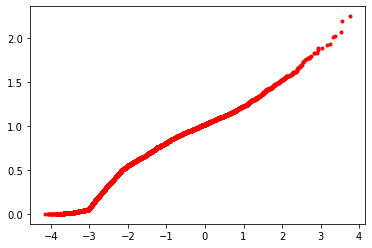

In [ ]:
plt.plot(variants_cata_wt_df["el2_score"], variants_cata_wt_df["el2_score_dist"], 'r.')

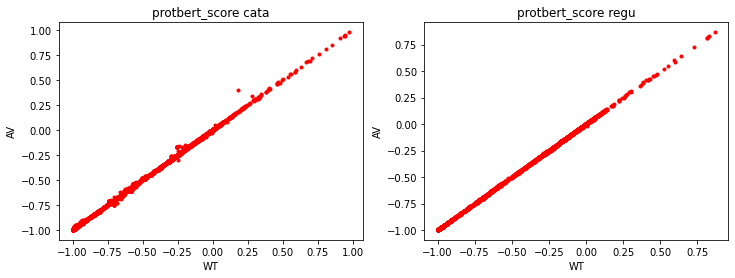

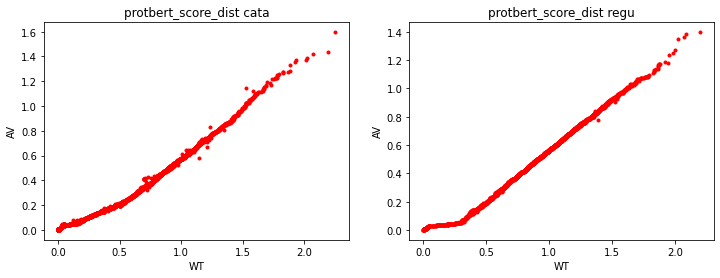

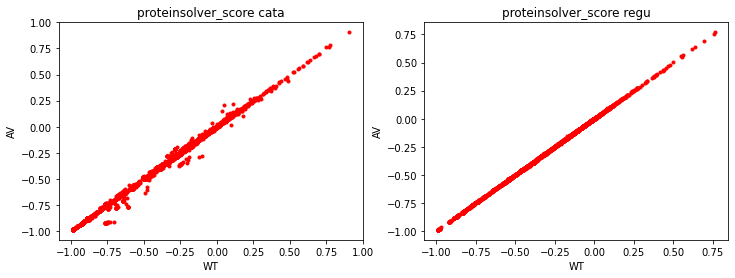

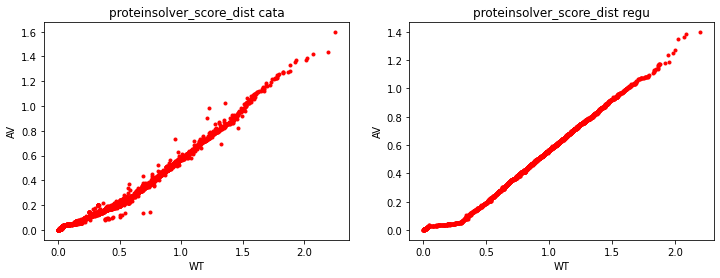

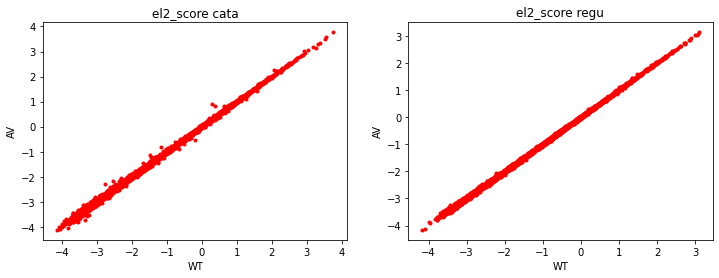

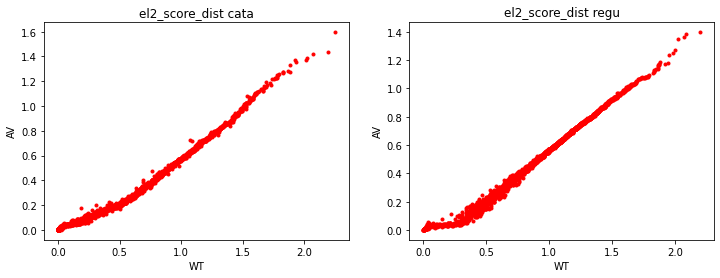

In [ ]:
for column_ref in feature_columns:
    for column in [column_ref, f"{column_ref}_dist"]:
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        ax = axs[0]
        ax.plot(variants_cata_wt_df[column], variants_cata_av_df[column], 'r.')
        ax.set_xlabel("WT")
        ax.set_ylabel("AV")
        ax.set_title(f"{column} cata")

        ax = axs[1]
        ax.plot(variants_regu_wt_df[column], variants_regu_av_df[column], 'r.')
        ax.set_xlabel("WT")
        ax.set_ylabel("AV")
        ax.set_title(f"{column} regu")